## REGRESSION ANALYSIS

### PREDICTING HEALTH INSURANCE PREMIUM USING MULTIPLE LINEAR REGRESSION

#### Source of data: __https://www.kaggle.com/code/yogidsba/insurance-claims-eda-hypothesis-testing/data__

#### About the Dataset
`age` : age of policyholder

`sex`: gender of policy holder (female=0, male=1)

`bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight $\frac{kg}{m ^ 2}$ using the ratio of height to weight, ideally $18.5$ to $25$ steps: average walking steps per day of policyholder

`children`: number of children / dependents of policyholder

`smoker`: smoking state of policyholder (non-smoke=0; smoker=1)

`region`: the residential area of policyholder in the US (northeast=0, northwest=1, southeast=2, southwest=3)

`charges`: individual medical costs billed by health insurance

#### Import libraries

In [3]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, pearsonr, norm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, accuracy_score)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### Read in the data

In [4]:
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Data Inspection
#### Get the general overview of the data

#### (i) Look at the shape of our data 

In [5]:
print(data.shape)

#The data has 7 columns and 1338 rows.

(1338, 7)


#### (ii) Examine the data types of the different columns

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


- The age column has integer values as expected
- Sex is categorical variable with two labels, male and female, and thus should be object data type.
- BMI column has decimal values therefore it has float data type.
- Children should be integer.
- Smoker is a categorical variable with two labels, yes or no, thus object.
- There are 4 regions represented in the dataset thus the column is of object data type.
- Charges should be float as it represents premiums paid. 

### Data Exploration

#### 1. Check for missing values

In [6]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- There are no missing values in all the columns

#### 2. The 5 number summary of numerical columns

In [7]:
data[["age", "bmi", "children", "charges"]].describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Explanatory Data Analysis

#### 1. Correlation heatmap

- This is used to check for multicollinearity between the indpendent variables.
- We exclude the 'charges' column because it will be our independent variable.

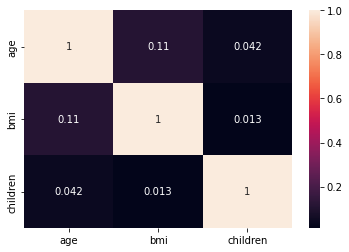

In [8]:
correlation = data.select_dtypes("number").drop(columns="charges").corr()
correlation

#Plot a heatmap to check for multicollinearity in the features except the target feature
sns.heatmap(correlation, annot=True);

- We can see that there is no significant multicollinearity between the numerical independent variables

### Correlation heatmap after encoding

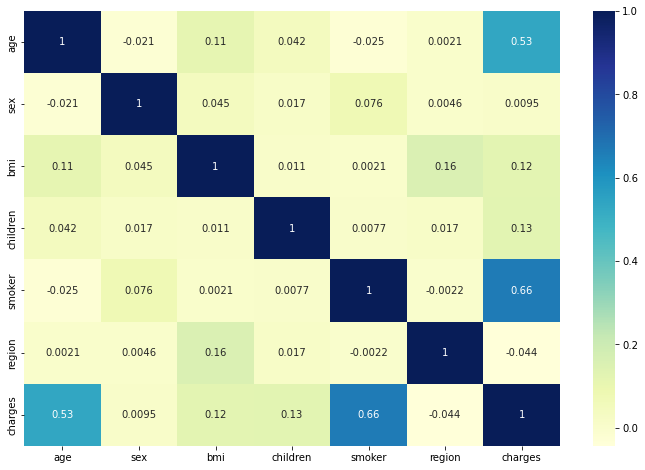

In [9]:
#Encode the categorical variables then plot heatmap
correlation = data.apply(LabelEncoder().fit_transform).select_dtypes("number").corr()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.heatmap(correlation, annot=True, cmap="YlGnBu")

We can there is a moderate correlation between 'smoker' and 'age' variables and charges.

#### 2. Data Visualizations

#### Encoding

###### When fitting a linear regression model, scikit-learn will do some mathematical operations. 'sex' column and 'smoker' column are non-numerical. Therefore, before building our models we need to encode these information so that it's represented numerically. 

###### We also need the encoded information to do detailed correlation analysis

In [27]:
#Encode the categorical variables 
cols = ["sex", "smoker", "region"]

data[cols] = data[cols].apply(LabelEncoder().fit_transform)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


#### 1. Correlation analysis

##### (i) How age is affecting charges

In [11]:
# Age vs Charges
cor = pearsonr(data.age, data.charges)
age_coef = round(cor[0], 4)
age_pv = round(cor[1], 6)

print("Correlation coefficient is: {}".format(age_coef))
print("Its p-value is: {}".format(age_pv))

Correlation coefficient is: 0.299
Its p-value is: 0.0


There exists a positive correlation between age and charges a person is paying, but the correlation is weak.

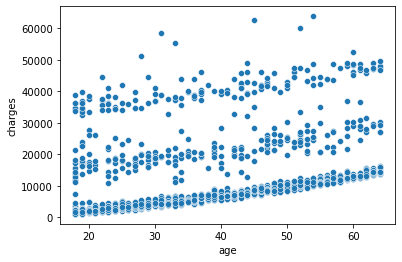

In [12]:
# Scatterplot of age and charges

sns.scatterplot(x='age',y='charges',data=data);

From this plot we can see the weak positive correlation between these two variables.

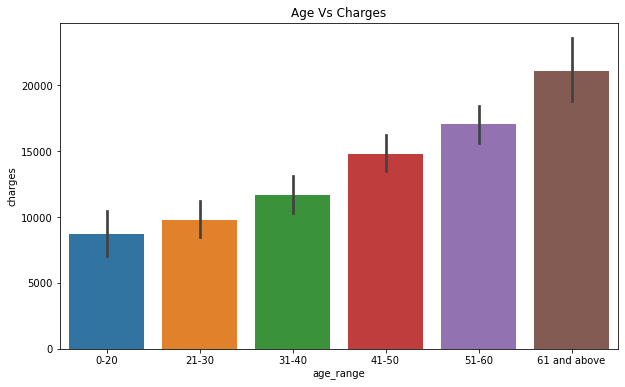

In [13]:
#Bar graph of Age and Charges
df = data.copy()
bins = [0,20,30,40,50,60,100]
df['age_range'] = pd.cut(df['age'], bins,labels=('0-20','21-30','31-40','41-50','51-60','61 and above'))
df.head()


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='age_range',y='charges',data = df).set(title='Age Vs Charges');

From this plot, we can see that as age increases, the charges also increases.

#### (ii) How is the smoker status affecting charges

In [14]:
# Smoker vs Charges
cor = pearsonr(data.smoker, data.charges)
smoker_coef = round(cor[0], 4)
smoker_pv = round(cor[1], 6)

print("Correlation coefficient is: {}".format(smoker_coef))
print("Its p-value is: {}".format(smoker_pv))

Correlation coefficient is: 0.7873
Its p-value is: 0.0


We can see that there is a strong positive correlation between smoker status and charges.

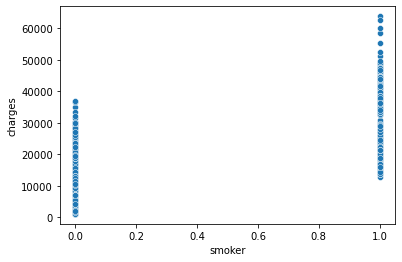

In [15]:
# Scatterplot of smoker and charges

sns.scatterplot(x='smoker',y='charges',data=data);

We can see that those who smoke are paying more than non-smokers.

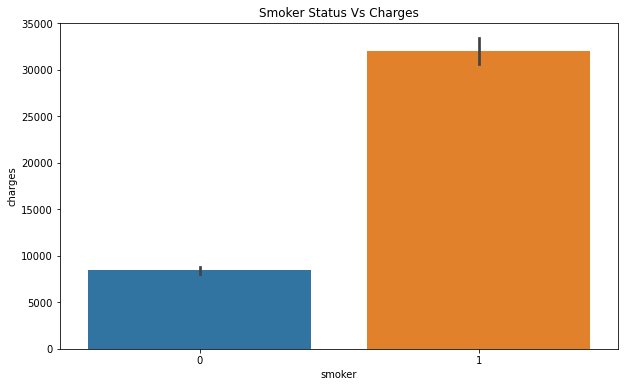

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='smoker',y='charges',data = data).set(title='Smoker Status Vs Charges');

We can see that charges for smokers are really high compared to non-smokers.

#### (iii) How do charges differ for the different gender

In [17]:
# Sex vs Charges
cor = pearsonr(data.sex, data.charges)
sex_coef = round(cor[0], 4)
sex_pv = round(cor[1], 6)

print("Correlation coefficient is: {}".format(sex_coef))
print("Its p-value is: {}".format(sex_pv))

Correlation coefficient is: 0.0573
Its p-value is: 0.036133


There is a weak positive correlation between sex and charges.

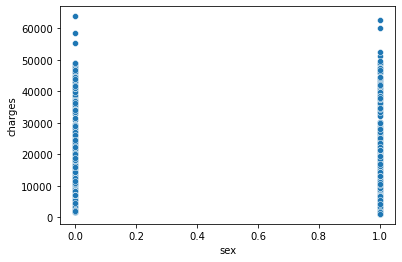

In [18]:
# Scatterplot of sex and charges

sns.scatterplot(x='sex',y='charges',data=data);

The charges paid by males and female are the same. There is no significant difference.

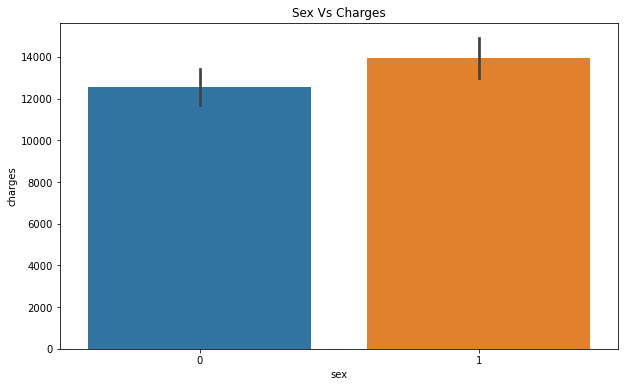

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='sex',y='charges',data = data).set(title='Sex Vs Charges');

Males and females almost pay equal charges. No significant difference.

#### (iv) How do BMI and Charges relate

In [20]:
# BMI vs Charges
cor = pearsonr(data.bmi, data.charges)
bmi_coef = round(cor[0], 4)
bmi_pv = round(cor[1], 6)

print("Correlation coefficient is: {}".format(bmi_coef))
print("Its p-value is: {}".format(bmi_pv))

Correlation coefficient is: 0.1983
Its p-value is: 0.0


There is a weak but significant positive correlation between bmi and charges

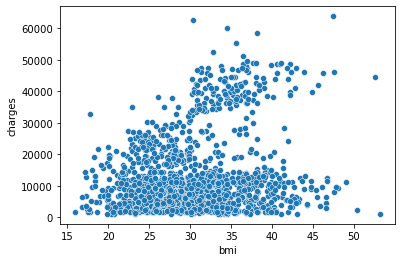

In [21]:
# Scatterplot of bmi and charges

sns.scatterplot(x='bmi',y='charges',data=data);

Most individuals pay charges around $10000. However, we can notice that the charges are more for some people with higher bmi.

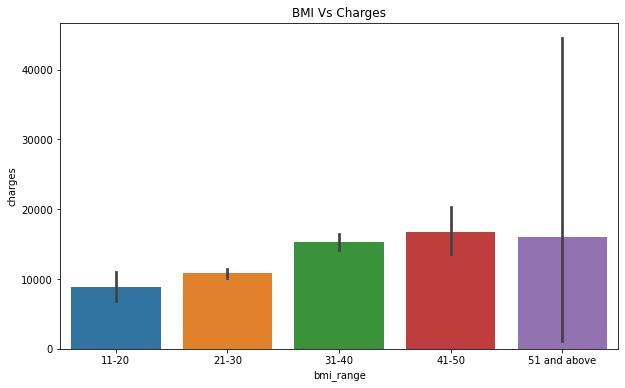

In [22]:
df = data.copy()
bins = [10,20,30,40,50,60]
df['bmi_range'] = pd.cut(df['bmi'], bins,labels=('11-20','21-30','31-40','41-50','51 and above'))
df.head()

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='bmi_range',y='charges',data = df).set(title='BMI Vs Charges');

We can see that charges increases progressively as bmi increases.

#### (v) Does the number of children affect charges

In [23]:
# Children vs Charges
cor = pearsonr(data.children, data.charges)
child_coef = round(cor[0], 4)
child_pv = round(cor[1], 6)

print("Correlation coefficient is: {}".format(child_coef))
print("Its p-value is: {}".format(child_pv))

Correlation coefficient is: 0.068
Its p-value is: 0.012852


There is a weak positive correlation between the number of children and charges paid. The coefficient is significant though.

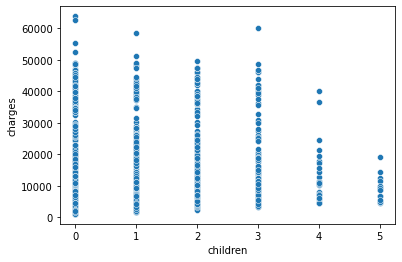

In [24]:
# Scatterplot of children and charges

sns.scatterplot(x='children',y='charges',data=data);

We can see that the number of children does not significantly affect the charges that individuals pay. Charges does not vary much.

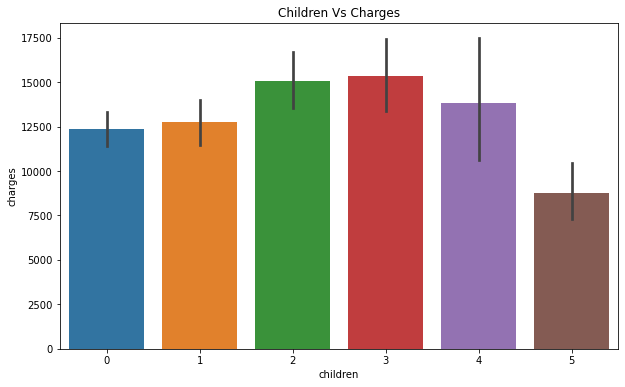

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='children',y='charges',data = data).set(title='Children Vs Charges');

There is almost uniform distribution of charges across the different numbers of children.

#### (vi) Does the region an individual come from really matter? 

In [28]:
# Region vs Charges
cor = pearsonr(data.region, data.charges)
region_coef = round(cor[0], 4)
region_pv = round(cor[1], 6)

print("Correlation coefficient is: {}".format(region_coef))
print("Its p-value is: {}".format(region_pv))

Correlation coefficient is: -0.0062
Its p-value is: 0.820518


There is a weak negative correlation between region and charges. Moreover, the correlation is not statistically significant.

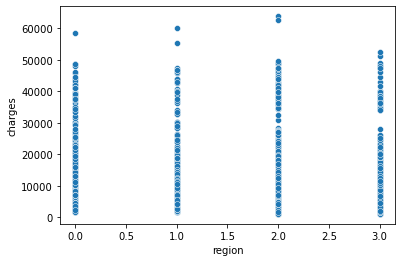

In [29]:
# Scatterplot of children and charges

sns.scatterplot(x='region',y='charges',data=data);

Individuals from the different regions pay approximately equal charges.

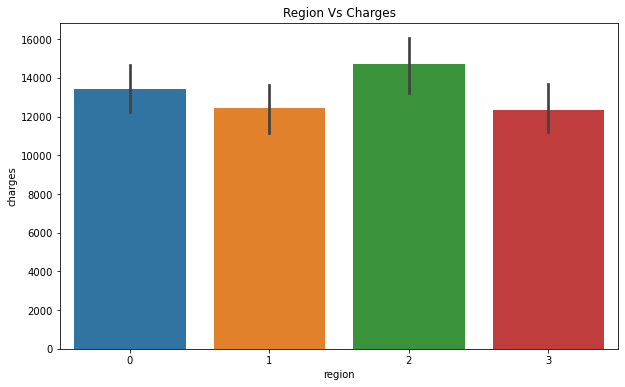

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='region',y='charges',data = data).set(title='Region Vs Charges');

The charges for the different regions are not significantly different.

##### We will drop the sex column and the region variable as we have seen that they are not statistically correlated with charges.

#### 2. Distribution plots

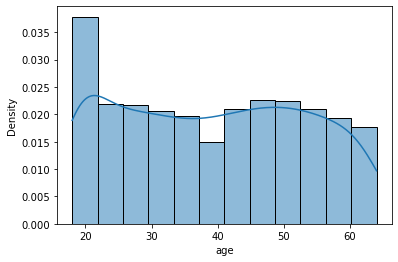

In [31]:
#age distribution
fig, ax = plt.subplots()

sns.histplot(data.age, stat="density", ax=ax, kde=True)

plt.show();

Age is approximately uniformly distributed

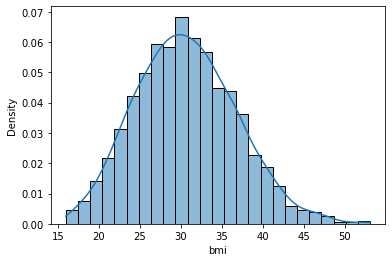

In [32]:
#bmi distribution
fig, ax = plt.subplots()

sns.histplot(data.bmi, stat="density", ax=ax, kde=True)

plt.show();

The bmi of policyholders is normally distributed

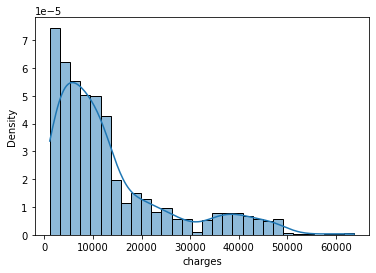

In [33]:
#charges distribution
fig, ax = plt.subplots()

sns.histplot(data.charges, stat="density", ax=ax, kde=True)

plt.show();

The amount of charges that the policyholders pay to the insurer are skewed to the right. There are a higher number of premiums that are below $20000

#### 3. Boxplots to detect outliers

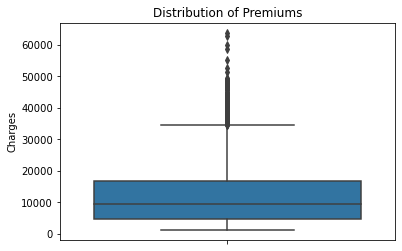

In [34]:
# Create boxplot to show the distributions of charges
fig, ax = plt.subplots()

sns.boxplot(y="charges", data=data, ax=ax)
# Label axes
plt.ylabel("Charges")
plt.title("Distribution of Premiums")

plt.show();

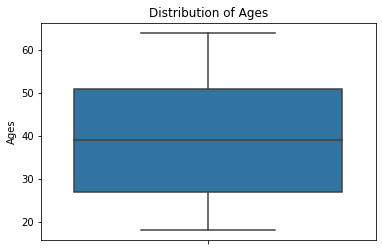

In [35]:
# Create boxplot to show age ranges of individuals
fig, ax = plt.subplots()

sns.boxplot(y="age", data=data, ax=ax)
# Label axes
plt.ylabel("Ages")
plt.title("Distribution of Ages")

plt.show();

There are no extreme ages.

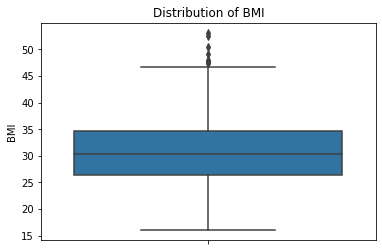

In [36]:
# Create boxplot to show the bmi ranges
fig, ax = plt.subplots()

sns.boxplot(y="bmi", data=data, ax=ax)
# Label axes
plt.ylabel("BMI")
plt.title("Distribution of BMI")

plt.show();

There are a few outliers in the bmi column. We can observe that some bmi are above 50.

There are a number of ouliers in the charges column. Some individuals are being charged extremely high premiums than the rest.

### Data Pre-Processing and Cleaning

#### Drop the 'region' and 'sex' columns

In [39]:
data.drop(columns=["sex", "region"], inplace = True)

### REGRESSION ANALYSIS

#### In this project we'll look into 3 different regression models. That is:
1. Simple Linear Regression
2. Multiple Linear Regression
3. Ridge Regression

Linear Regression is a machine learning algorithm that models a target prediction value based on independent variables. This is an algorithm that is based on supervised learning.
It is mostly used for finding out the relationship between variables and forecasting.

### 1. Simple Linear Regression

For the simple linear regression I will use the bmi variable as the independent variable.
I have picked the bmi variable because it is one of the continuous variable that had significant correlation with charges

#### Data selection

In [45]:
target = "charges"
features = "bmi"

y = data[target]
X = data[[features]]

#### Split data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (1070, 1) (1070,)
Test set: (268, 1) (268,)


#### Build Model

In [47]:
#Instantiate the linear regression model
simple_model = LinearRegression()

#Train the model
simple_model.fit(X_train, y_train)

LinearRegression()

#### Model predictions

In [48]:
y_hat = simple_model.predict(X_test)

#Check a few lines of the predictions
y_hat[:5]

array([11232.66307168, 13134.01812818, 11903.72956221, 11456.35190186,
       13879.64756211])

#### Plot the regression line

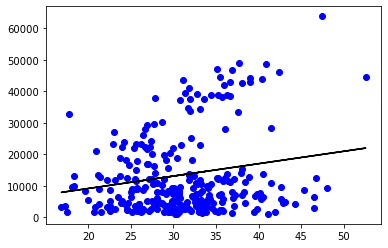

In [49]:
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_hat, color ='k')
  
plt.show();

The regression line doesn't fit the data well.

#### Model Evaluation

In [50]:
#R-Squared
r2 = r2_score(y_test, y_hat)
print('R-Squared:', r2)

#MAE
mae = mean_absolute_error(y_test, y_hat)
print('Mean Absolute Error:', mae)

#mse
mse = mean_squared_error(y_test, y_hat)
print('Mean Squared Error:', mse)

#rmse
rmse = mean_squared_error(y_test, y_hat, squared=False)
print('Root Mean Squared Error:', rmse)

#create a list of the metrics 
simple_model_metrics = [r2, mae, mse, rmse]
simple_model_metrics

#create a dataframe of the metrics
simple_metrics = pd.DataFrame(simple_model_metrics, 
                          index=["R-squared", "MAE", "MSE", "RMSE"], 
                          columns=["Score"])
simple_metrics

R-Squared: 0.03970193117941878
Mean Absolute Error: 9784.652596271331
Mean Squared Error: 149085057.03839505
Root Mean Squared Error: 12210.039190698571


,Score
R-squared,3.970193e-02
MAE,9.784653e+03
MSE,1.490851e+08
RMSE,1.221004e+04


### 2. Multiple Linear Regression

#### Data selection

In [51]:
target = "charges"
y = data[target]

X = data.drop(columns=target)

#### Split data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (1070, 4) (1070,)
Test set: (268, 4) (268,)


#### Build Model

In [53]:
#Instantiate the model
multiple_model = LinearRegression()

#Fit the model to training data
multiple_model.fit(X_train, y_train)

LinearRegression()

#### Make predictions

In [54]:
y_hat = multiple_model.predict(X_test)

#Check a few lines of the predictions
y_hat[:5]

array([ 8550.90921341,  6969.71599759, 36794.13661808,  9421.86824203,
       26875.01095777])

#### Model Evaluation

In [56]:
#R-Squared
r2 = r2_score(y_test, y_hat)
print('R-Squared:', r2)

#MAE
mae = mean_absolute_error(y_test, y_hat)
print('Mean Absolute Error:', mae)

#mse
mse = mean_squared_error(y_test, y_hat)
print('Mean Squared Error:', mse)

#rmse
rmse = mean_squared_error(y_test, y_hat, squared=False)
print('Root Mean Squared Error:', rmse)

#create a list of the metrics 
multiple_model_metrics = [r2, mae, mse, rmse]
multiple_model_metrics

#create a dataframe of the metrics
multiple_metrics = pd.DataFrame(multiple_model_metrics, 
                          index=["R-squared", "MAE", "MSE", "RMSE"], 
                          columns=["Score"])
multiple_metrics

R-Squared: 0.7811147722517887
Mean Absolute Error: 4213.798594527248
Mean Squared Error: 33981653.95019775
Root Mean Squared Error: 5829.378521780666


,Score
R-squared,7.811148e-01
MAE,4.213799e+03
MSE,3.398165e+07
RMSE,5.829379e+03


### 3. Ridge Regression

sklearn.linear_model.Ridge is the module used to solve a regression model where loss function is the linear least squares function and regularization is L2

#### Data selection

In [57]:
target = "charges"
y = data[target]

X = data.drop(columns=target)

#### Split data

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (1070, 4) (1070,)
Test set: (268, 4) (268,)


#### Build Model

In [59]:
#Instantiate the model
ridge_model = Ridge(random_state=42)

#Fit the model to training data
ridge_model.fit(X_train, y_train)

Ridge(random_state=42)

#### Model predictions

In [60]:
y_hat = ridge_model.predict(X_test)

#Check a few lines of the predictions
y_hat[:5]

array([ 8577.84674681,  6997.59146985, 36681.20908142,  9449.11311462,
       26771.46745829])

#### Model Evaluation

In [62]:
#R-Squared
r2 = r2_score(y_test, y_hat)
print('R-Squared:', r2)

#MAE
mae = mean_absolute_error(y_test, y_hat)
print('Mean Absolute Error:', mae)

#mse
mse = mean_squared_error(y_test, y_hat)
print('Mean Squared Error:', mse)

#rmse
rmse = mean_squared_error(y_test, y_hat, squared=False)
print('Root Mean Squared Error:', rmse)

#create a list of the metrics 
ridge_model_metrics = [r2, mae, mse, rmse]
ridge_model_metrics

#create a dataframe of the metrics
ridge_metrics = pd.DataFrame(ridge_model_metrics, 
                          index=["R-squared", "MAE", "MSE", "RMSE"], 
                          columns=["Score"])
ridge_metrics

R-Squared: 0.7808720464897415
Mean Absolute Error: 4225.750279059395
Mean Squared Error: 34019336.816855945
Root Mean Squared Error: 5832.609777522918


,Score
R-squared,7.808720e-01
MAE,4.225750e+03
MSE,3.401934e+07
RMSE,5.832610e+03


### Summary of evaluation metrics

In [63]:
#Dataframe of evaluation metrics for all the models
evaluation_metrics_df = pd.DataFrame(
    {
    'Simple Linear Regression': simple_model_metrics,
    'Multiple Linear Regression': multiple_model_metrics,
    'Ridge Regression': ridge_model_metrics
    },
    index = ['R-Squared', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error']
)

evaluation_metrics_df

,Simple Linear Regression,Multiple Linear Regression,Ridge Regression
R-Squared,3.970193e-02,7.811148e-01,7.808720e-01
Mean Absolute Error,9.784653e+03,4.213799e+03,4.225750e+03
Mean Squared Error,1.490851e+08,3.398165e+07,3.401934e+07
Root Mean Squared Error,1.221004e+04,5.829379e+03,5.832610e+03


### Conclusion

R-squared gives the proportion of variation in the target variable that is explained by the combination of independent variables in the model. A high value of R-squared indicates that much of the variation has been explained by the model and hence the model is a good fir to the data.

Mean squared error measures the amount of error in the regression models. It will assess the average squared difference between the true values and the predicted values. A small value of mean squared error is desireable as it shows that the true values and the predicted values do not differ much. A good model should therefore have a small mean square error.

Root mean squared error is just the square root of mean absolute error. A good model should have a small root mean squared error.

Mean absolute error measures the absolute difference between true values and predicted values. It is thus desireable for a good model to have a small mean absolute error as an indication that the predicted values are close to the true values.

#### Using the evaluation metrics above, we can see that the multiple linear regression model performed better than the other models.

#### The multiple linear regression has the highest value of R-squared, a value of 78.11%.
#### This shows that it is a good fit to the data and hence the best model to predict the amount of charges (premium) that an individual will pay given the independent health related variables.

### Feature importances of the Best Model

This shows us the weights of the different independent variables in predicting the dependent variable, charges

In [64]:
#get coefficients
coefficients = multiple_model.coef_

#create a pandas series with the importances
feat_imp = pd.Series(coefficients, index=X_train.columns)

feat_imp

age           257.071158
bmi           327.522631
children      427.199971
smoker      23653.211646
dtype: float64

##### Create a horizontal bar graph to show the order of importance of independent variables based on absolute value

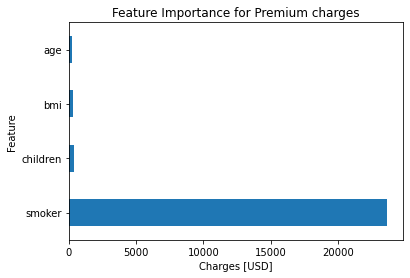

In [65]:
feat_imp.sort_values(key=abs, ascending=False).plot(kind='barh')
plt.xlabel('Charges [USD]')
plt.ylabel('Feature')
plt.title('Feature Importance for Premium charges');

##### Smoker variable (the smoking status of an individual)  is the top feature in predicting the amount of premium an individual will pay.
##### Smoking increases the amount of premium paid.